In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ca_cardiac_model
import optimap as om
import math
import random


In [2]:

print(ca_cardiac_model.cardiac_simulation.__doc__)  # Assuming 'test' is your subroutine name


v_out,cb_out,csrb_out,ci_out,t_out,num_steps = cardiac_simulation(lx,ly,nstim,iseed,rbcl,dfu,gicai,gtos,gtof,gnacai,zxr,nbt,cxinit,xnai,xnao,xki,xko,cao,temp,xxr,xf,dt,max_buffer_size,mod_output,parallel_exec,stimulus_function,[stimulus_function_extra_args])

Wrapper for ``cardiac_simulation``.

Parameters
----------
lx : input int
ly : input int
nstim : input int
iseed : input int
rbcl : input float
dfu : input float
gicai : input float
gtos : input float
gtof : input float
gnacai : input float
zxr : input float
nbt : input int
cxinit : input float
xnai : input float
xnao : input float
xki : input float
xko : input float
cao : input float
temp : input float
xxr : input float
xf : input float
dt : input float
max_buffer_size : input int
mod_output : input int
parallel_exec : input int
stimulus_function : call-back function

Other Parameters
----------------
stimulus_function_extra_args : input tuple, optional
    Default: ()

Returns
-------
v_out : rank-3 array('d') with bounds (max_b

In [3]:
# Set parameters from the provided defaults
lx = 300  # Assuming a small grid size, adjust as needed
ly = 300  # Assuming a small grid size, adjust as needed
nstim = 2  # Number of stimuli, adjust as needed
iseed = 823323  # Initial random number seed
rbcl = 1000.0  # Pacing rate
dfu = 0.0001  # Effective voltage diffusion coefficient

# Ionic current parameters
gicai = 2.20  # Strength of LCC
gtos = 0.04  # Strength of ito slow
gtof = 0.15  # Strength of ito fast
gnacai = 1.5  # Strength of NCX

zxr = 0.09  # Controls degree of Ca-induced inactivation

nbt = 4000  # Total number of RyR2 clusters
cxinit = 1200.0  # Initial SR load

# Sodium concentration calculation
xmx = -2.0/250.0
xnai = xmx * 520.0 + 16.0  # Constant Na concentration

# Constants
xnao = 136.0  # External Na (mM)
xki = 140.0  # Internal K (mM)
xko = 5.40  # External K (mM)
cao = 1.8  # External Ca (mM)

temp = 308.0  # Temperature (K)
xxr = 8.314  # Gas constant
xf = 96.485  # Faraday's constant

dt = .5  # Time step
parallel = False # RK4

mod_output = 10 

nstep = rbcl/dt 

max_buffer_size = math.ceil((nstep*nstim) /mod_output) + (nstim)


def stimulus_function(ix, iy, time):
    # Example: Stimulate a 10x10 corner for the first 1ms
    if time < 1.0 and ix < 5 and iy < 5:
        return 80.0
    else:
        return 0.0


In [4]:

def random_stimulus_function(ix, iy, time, new_stimulus_probability=0.001):
    #print(ix,iy,time)
    if(True):
        if(random.random()<new_stimulus_probability):
            return 120
        else:
            return 0
    else:
        return 0


current_time = 0
points = np.meshgrid(range(1,ly),range(1,lx))
launch = False

In [4]:
# Global variables to maintain state between calls
last_time_checked = -1
stimulus_centers = []
stimulus_active = False
stimulus_start_time = 0

def localized_random_stimulus(ix, iy, time, radius=5, stim_duration=1.0, time_prob=0.01):
    global last_time_checked, stimulus_centers, stimulus_active, stimulus_start_time
    
    # Check if we're at a new time point
    if abs(time - last_time_checked) > 1e-6:  # Floating point comparison
        last_time_checked = time
        
        # If stimulus is active, check if it should end
        if stimulus_active and (time - stimulus_start_time > stim_duration):
            stimulus_active = False
        
        # Randomly decide to start a new stimulus
        if not stimulus_active and random.random() < time_prob:
            stimulus_active = True
            stimulus_start_time = time
            # Choose a random center point
            center_x = random.randint(1, lx)
            center_y = random.randint(1, ly)
            stimulus_centers = [(center_x, center_y)]
    
    # Check if current point is within the stimulus radius of any center
    
    if stimulus_active:
        #print(stimulus_active)
        for center_x, center_y in stimulus_centers:
            distance = ((ix - center_x)**2 + (iy - center_y)**2)**0.5
            if distance <= radius:
                return 80.0  # Return stimulus current
    
    return 0.0  # No stimulus

In [5]:
%%time
v_out, cb_out, csrb_out, ci_out, t_out, num_steps = ca_cardiac_model.cardiac_simulation(
        lx, ly, nstim, iseed, rbcl, dfu, gicai, gtos, gtof, gnacai, zxr, nbt, 
        cxinit, xnai, xnao, xki, xko, cao, temp, xxr, xf, dt,
        max_buffer_size,mod_output,parallel,localized_random_stimulus
    )

CPU times: user 3min 6s, sys: 172 ms, total: 3min 6s
Wall time: 3min 7s


## Look at output shapes

In [6]:
v_out.shape

(402, 300, 300)

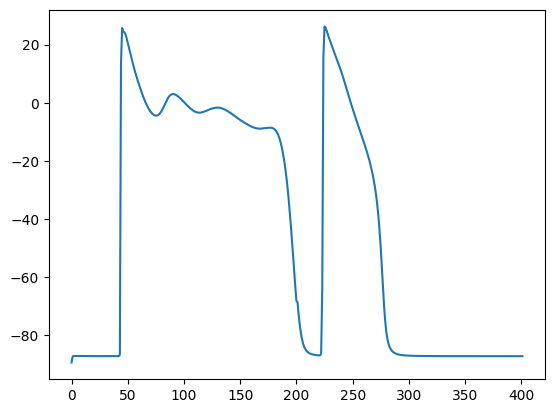

In [7]:
#plt.xlim([0,510])
plt.plot(v_out[:,50,50])

In [8]:
#video_voltage = om.load_video(v_out)
video_voltage = om.video.normalize_pixelwise((v_out))
video_csrb = om.video.normalize_pixelwise((cb_out))
video_cb = om.video.normalize_pixelwise((csrb_out))
video_ci = om.video.normalize_pixelwise((ci_out))

voltage_phase = om.phase.compute_phase(v_out)


'''
video_voltage = om.video.normalize_pixelwise(v_out)
video_csrb = om.video.normalize_pixelwise(cb_out)
video_cb = om.video.normalize_pixelwise(csrb_out)
video_ci = om.video.normalize_pixelwise(ci_out)
'''

'\nvideo_voltage = om.video.normalize_pixelwise(v_out)\nvideo_csrb = om.video.normalize_pixelwise(cb_out)\nvideo_cb = om.video.normalize_pixelwise(csrb_out)\nvideo_ci = om.video.normalize_pixelwise(ci_out)\n'

In [13]:
om.show_videos([v_out,video_voltage, video_csrb, video_cb,video_ci], titles=["V-phase","Voltage", "Csrb", "Cb","Ci"],vmins=[v_out.min(),0,0,0,0],vmaxs=[v_out.max(),1,1,1,1]);

In [10]:
om.export_videos(
    "voltage_ca_spiral_300_300.mp4",
    [video_voltage, video_csrb, video_cb,video_ci],
    fps=120,
    ncols=2,
    vmins=0,
    vmaxs=1
)

exporting video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 202.11it/s]


Video exported to voltage_ca_spiral_300_300.mp4


In [11]:
om.show_video(voltage_phase, title='removed outliers', cmap='hsv');